In [2]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import math
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


In [3]:
nside = 2**2

In [4]:
#Set up a new set of parameters for CAMB
pars = camb.read_ini('/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/params_camb_for_PTEP.ini')
#Set WantTensors to True
pars.WantTensors = True
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=1)
pars.set_for_lmax(3*nside - 1, lens_potential_accuracy=0)
random_seed = 5123
pars.RandomSeed = random_seed;

In [5]:
#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, lmax = 3*nside - 1, CMB_unit='muK', raw_cl=True)
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [6]:
cl_scal = powers['unlensed_scalar']
cl_tens = powers['tensor']
cl_lens = powers['lensed_scalar']
cl_pot = powers['lens_potential']
cl_total = powers['total']

r = 0.01

cl = cl_scal + r * cl_tens + cl_lens

#without lense
#cl = cl_scal + r * cl_tens

In [7]:
import healpy as hp
seed = 12345
np.random.seed(seed)
cmb_map = hp.synfast(cl.T, nside, new = True)

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
Synch = pysm3.Sky(nside, preset_strings=["s1"])

In [10]:
Synch.components

In [11]:
map_Synch_40GHz = Synch.get_emission(40 * u.GHz)
map_Synch_140GHz = Synch.get_emission(140 * u.GHz)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
map_Synch_40GHz = map_Synch_40GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(40*u.GHz))
map_Synch_140GHz = map_Synch_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz))

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
#hp.mollview(map_CMB_140GHz[0], title=" map", unit = map_CMB_140GHz.unit)
#hp.mollview(map_Synch_40GHz[2], title=" map", unit = map_Synch_40GHz.unit)
#hp.mollview(map_Synch_140GHz[0], title=" map", unit = map_Synch_140GHz.unit)

## Clean MAP

In [15]:
N_pix = hp.nside2npix(nside)

## $\vec{m} = ({[Q,U]_{\nu_1}(\hat{n}_i)},...,{[Q,U]_{\nu_{Nfreq}}(\hat{n}_{i})})$

In [16]:
# Data m

data_m = pysm3.Sky(nside, preset_strings=["s1"])

## $\vec{m}$ for each channel

In [17]:
m_40GHz = data_m.get_emission(40 * u.GHz)
m_140GHz = data_m.get_emission(140 * u.GHz)
m_50GHz = data_m.get_emission(50 * u.GHz)
m_100GHz = data_m.get_emission(100 * u.GHz)

# μK_R to μK_CMB

m_40GHz = m_40GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(40*u.GHz)).value + cmb_map
m_140GHz = m_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz)).value + cmb_map
m_50GHz = m_50GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(50*u.GHz)).value + cmb_map
m_100GHz = m_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz)).value + cmb_map

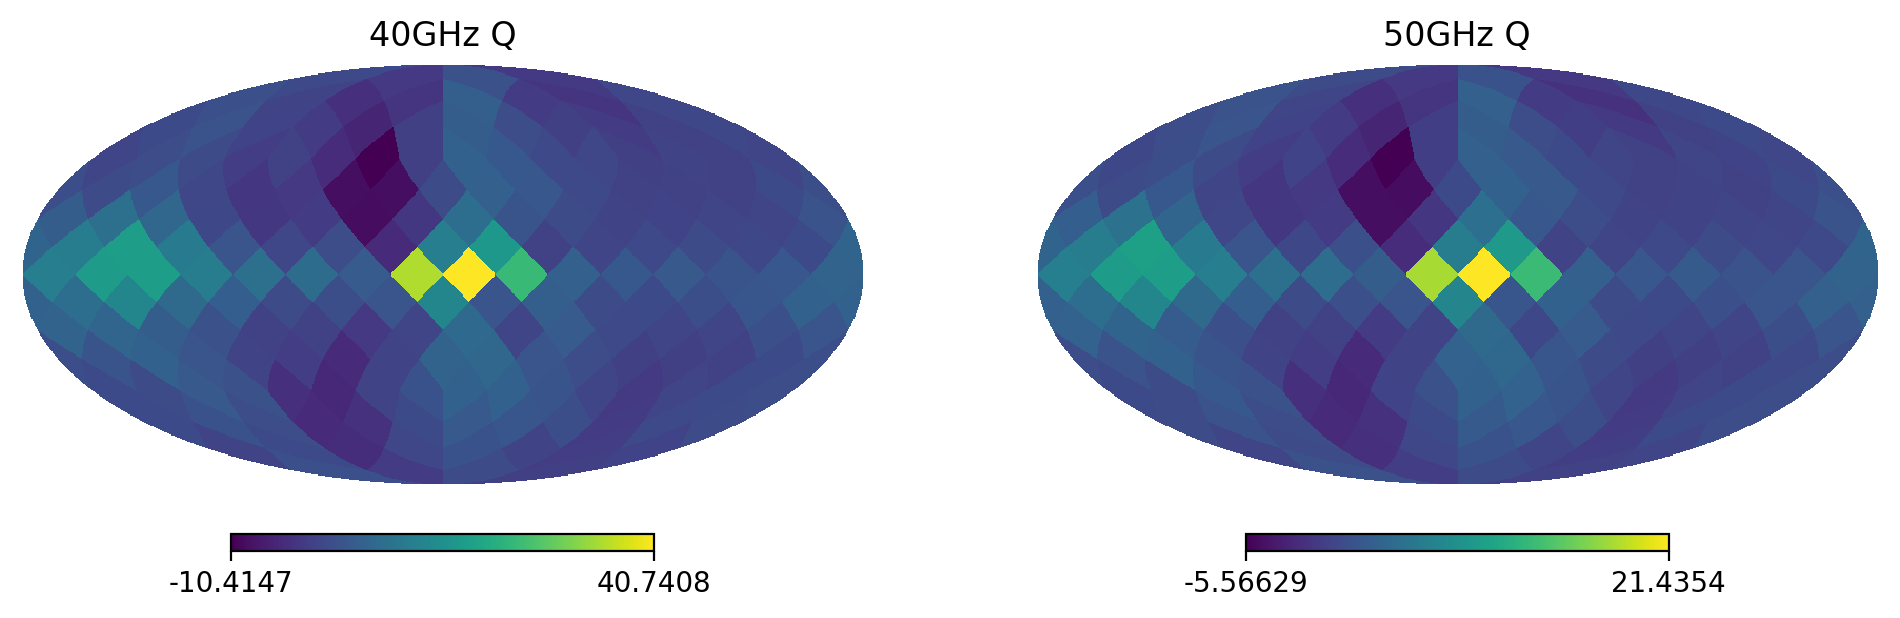

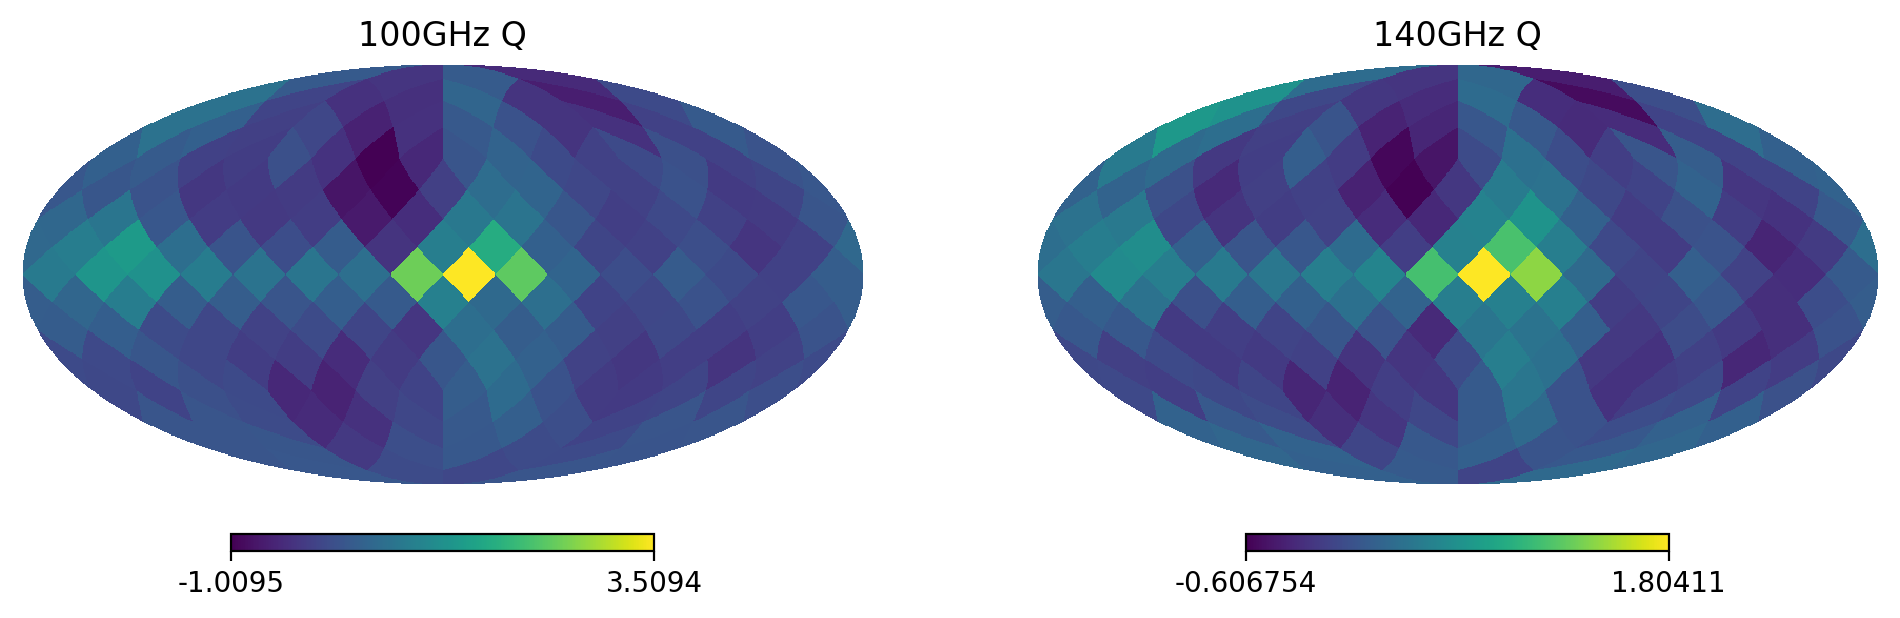

In [18]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_40GHz[1], title="40GHz Q", hold=True)

plt.axes(ax2)
hp.mollview(m_50GHz[1], title="50GHz Q", hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_100GHz[1], title="100GHz Q",hold=True)

plt.axes(ax2)
hp.mollview(m_140GHz[1], title="140GHz Q",hold=True)

## Q, U of m for each channel

In [19]:
m_40GHz_Q = m_40GHz[1]
m_50GHz_Q = m_50GHz[1]
m_100GHz_Q = m_100GHz[1]
m_140GHz_Q = m_140GHz[1]

m_40GHz_U = m_40GHz[2]
m_50GHz_U = m_50GHz[2]
m_100GHz_U = m_100GHz[2]
m_140GHz_U = m_140GHz[2]

In [20]:
data_m = [m_40GHz, m_100GHz, m_140GHz]

## D elements

### $\nu_{b*} = 23$ GHz, $\beta_s = -3.0$

In [21]:
import sys
sys.path.append('/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function')
import alpha_Delta_map as dm

In [22]:
freq_band = [40, 100, 140]
#freq_band = [40, 50, 100, 140, 280, 402]
cmb_freq = 140

Amat = dm.Amat_calc(freq_band, cmb_freq, "s1", freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)
print(Amat.shape)

s_cmb, d_cmb, g_cmb = dm.d_s_vec_calc(cmb_freq, freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)

(2, 2)


In [23]:
Amat

array([[198.10299377,  15.65577011],
       [109.62727239,  23.00890912]])

In [24]:
vec_cmb = np.vstack([s_cmb])

In [25]:
from numpy.linalg import solve as bslash

# N + M +3 = Nfreq ===> just number of frequency bands (Synch + Dust)
# N + 2 = Nfreq ===> just number of frequency bands (Dust)
# M + 2 = Nfreq ===> just number of frequency bands (Synch)

alpha = - bslash(Amat, vec_cmb)

In [26]:
clean_map_Q = (alpha[0]*data_m[0][1]+alpha[1]*data_m[1][1]+data_m[2][1])/(1 + sum(alpha))
clean_map_U = (alpha[0]*data_m[0][2]+alpha[1]*data_m[1][2]+data_m[2][2])/(1 + sum(alpha))

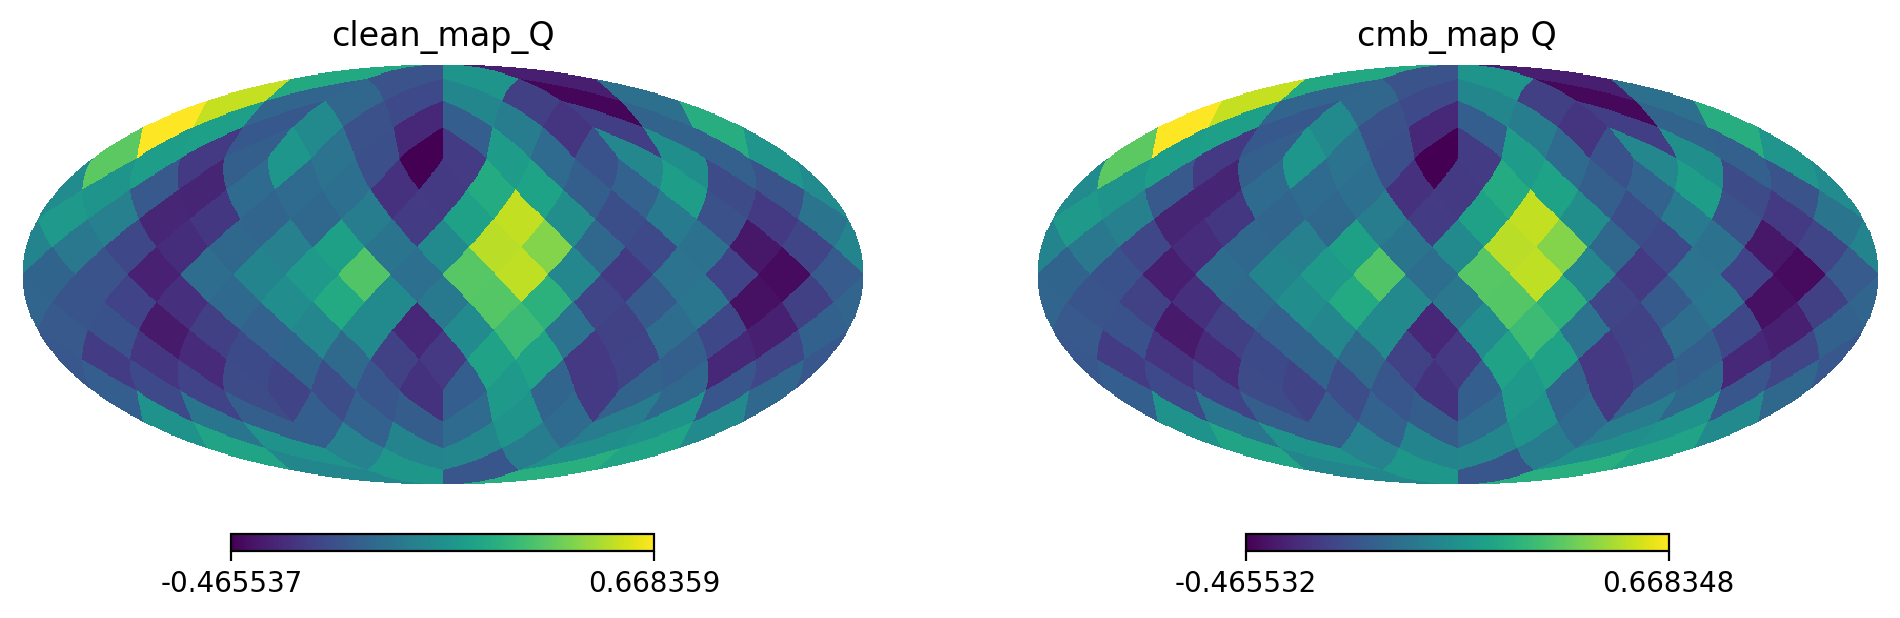

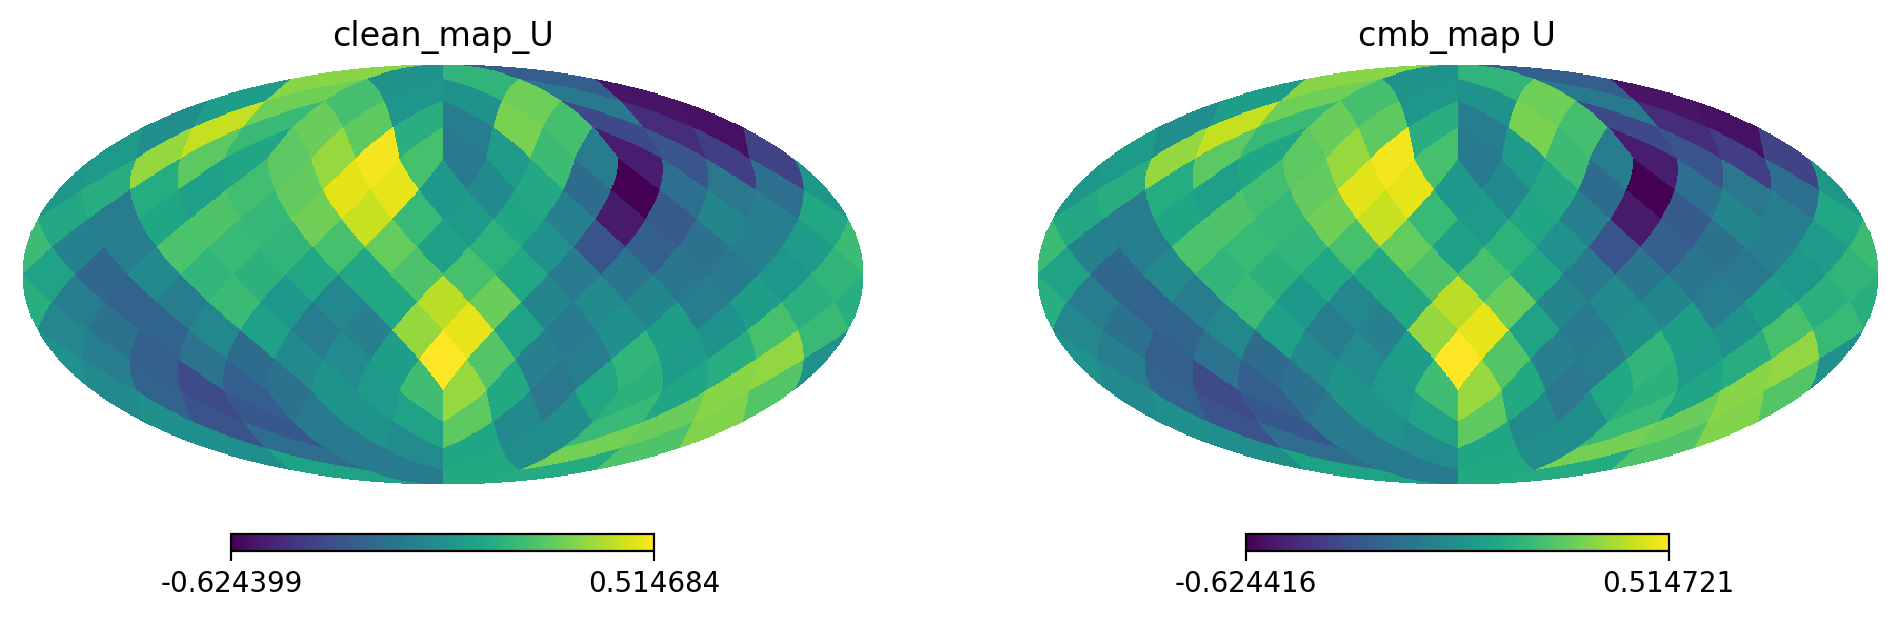

In [27]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(clean_map_Q, title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[1], title="cmb_map Q",hold=True)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax2)
hp.mollview(cmb_map[2], title="cmb_map U",hold=True)

plt.axes(ax1)
hp.mollview(clean_map_U, title="clean_map_U", hold=True)

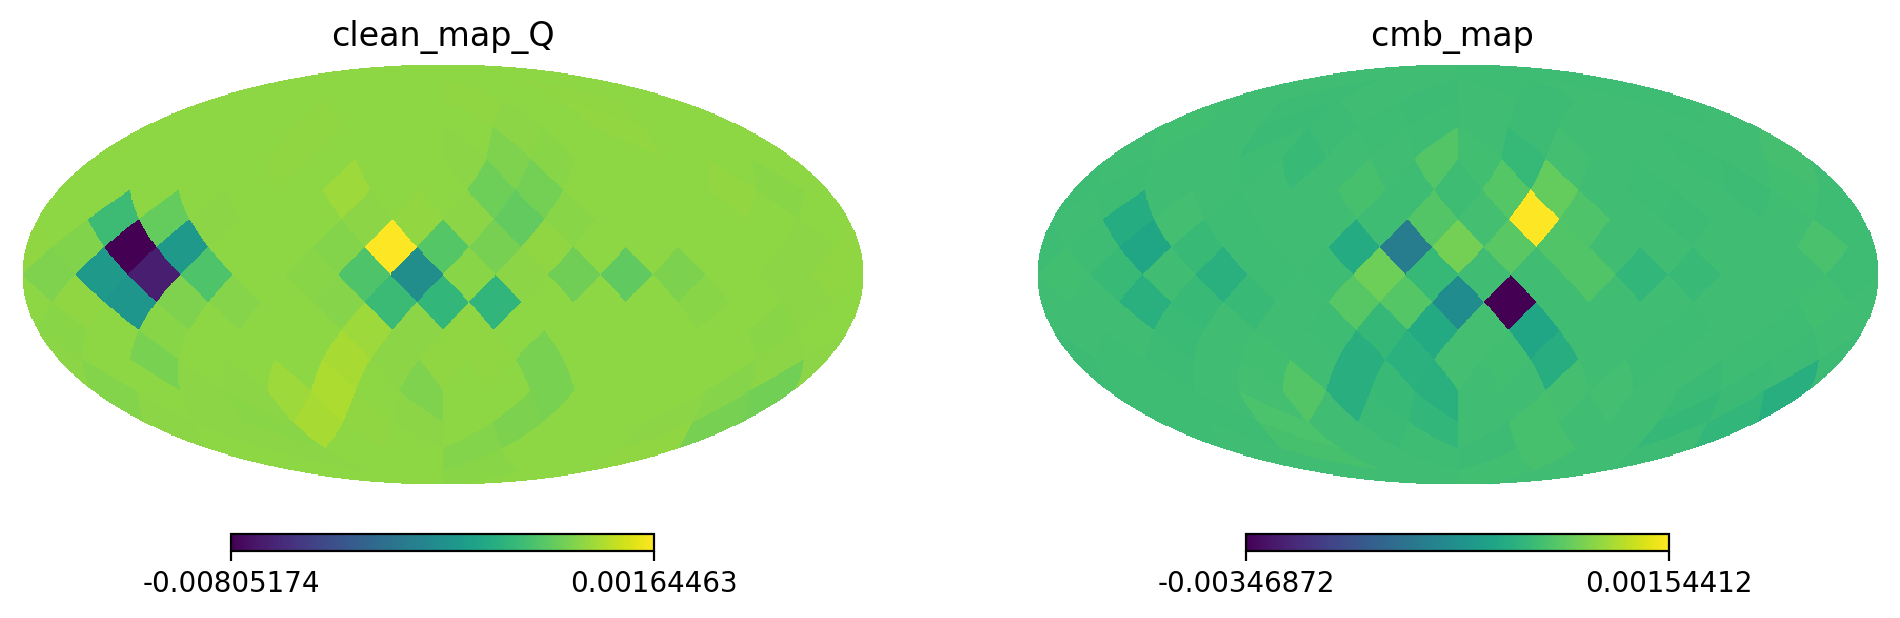

In [28]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(-clean_map_Q + cmb_map[1], title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(-clean_map_U + cmb_map[2], title="cmb_map ",hold=True)

### Power spectrum

In [86]:
I = np.zeros(N_pix)

Clean_map = [I, clean_map_Q, clean_map_U]

Input_map = [I, cmb_map[1], cmb_map[2]]

"""
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plt.axes(ax1)
hp.mollview(Clean_map[2], title="140GHz Q",hold=True)
plt.axes(ax2)
hp.mollview(CMB_map_U, title="140GHz Q",hold=True)
"""

'\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\nplt.axes(ax1)\nhp.mollview(Clean_map[2], title="140GHz Q",hold=True)\nplt.axes(ax2)\nhp.mollview(CMB_map_U, title="140GHz Q",hold=True)\n'

In [89]:
import math

l = np.arange(0, 3*nside, 1)

Clean_map_cl = hp.sphtfunc.anafast(Clean_map)

Input_map_cl = hp.sphtfunc.anafast(Input_map)

Clean_map_dl = Clean_map_cl * l * (l + 1) / (2 * math.pi)

Input_map_dl = Input_map_cl * l * (l + 1) / (2 * math.pi)

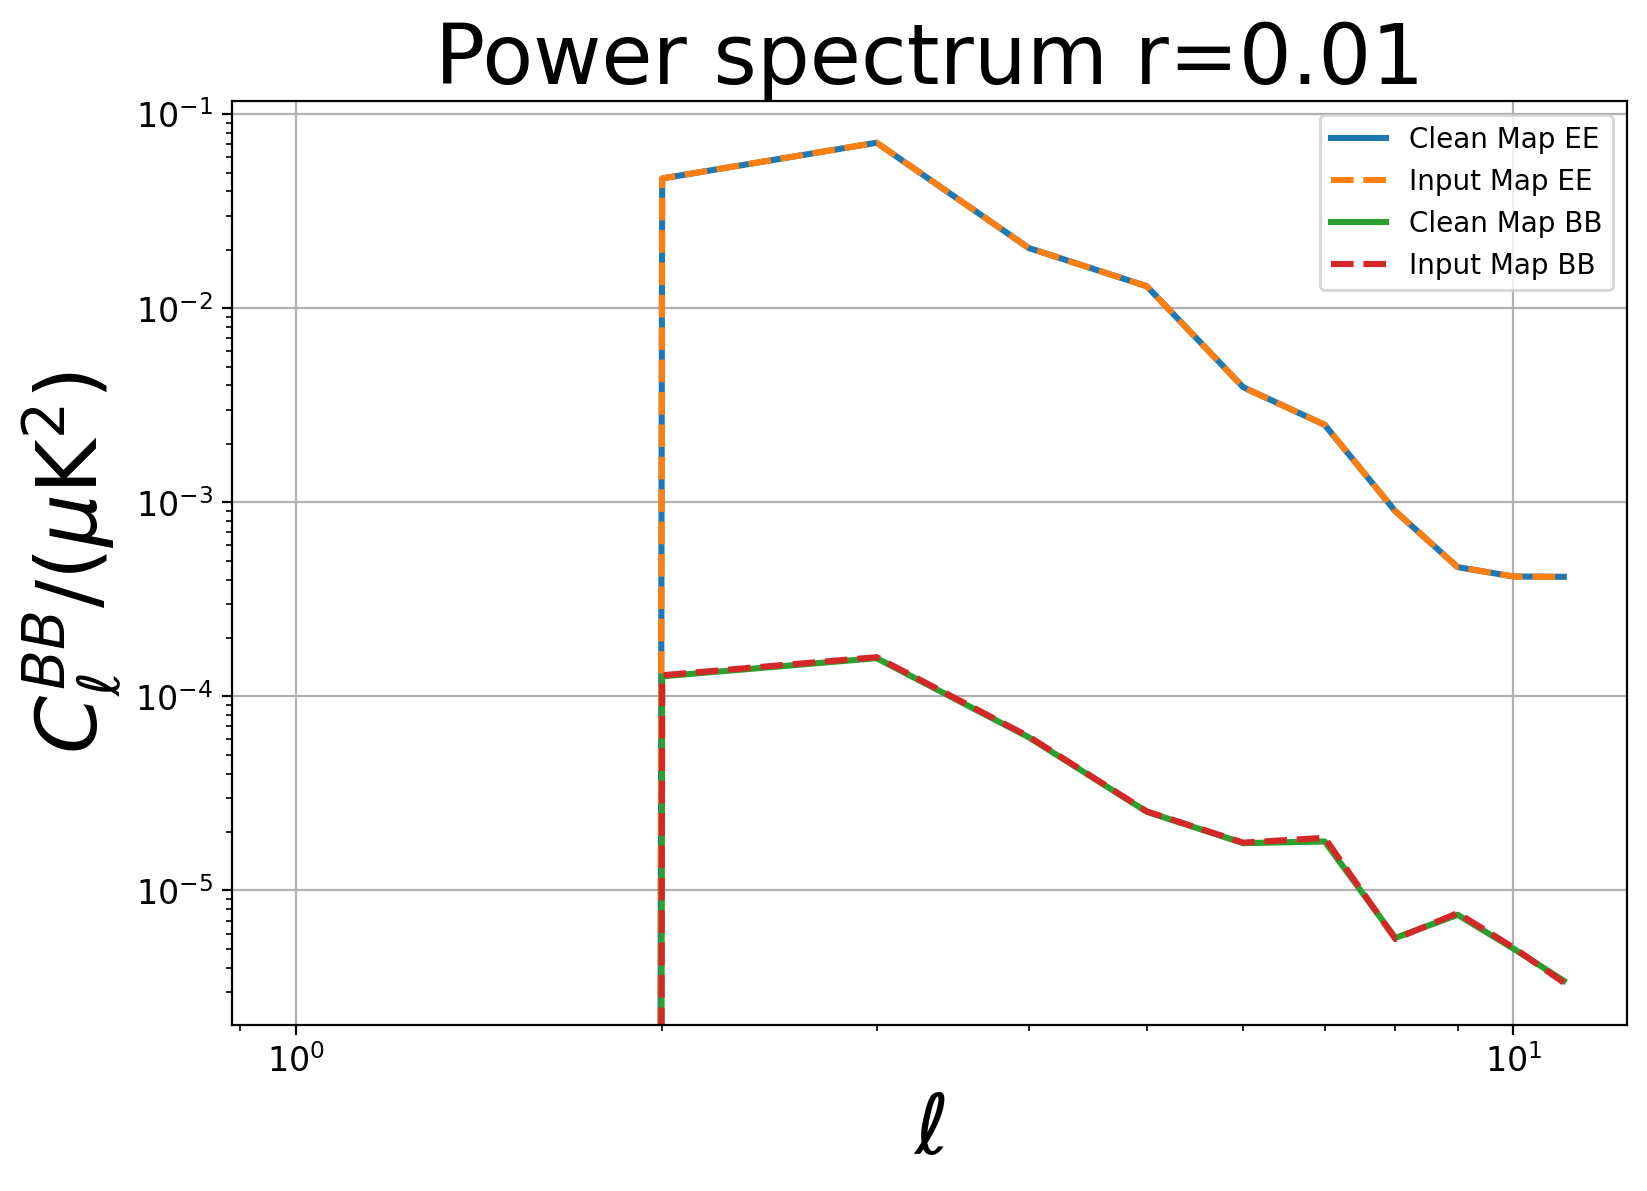

In [90]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.loglog(l, Clean_map_cl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_cl[1], lw=2.2, linestyle='dashed', label="Input Map EE")

"""
np.save("cl_file/Clean_cl_s1_EE_new.npy", Clean_map_cl[1])
np.save("cl_file/Input_cl_s1_EE_new.npy", Clean_map_cl[1])
"""

plt.loglog(l, Clean_map_cl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_cl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

"""
np.save("cl_file/Clean_cl_s1_BB_new.npy", Clean_map_cl[2])
np.save("cl_file/Input_cl_s1_BB_new.npy", Clean_map_cl[2])
"""

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=30)
plt.xlabel(r'$\ell$', fontsize=30)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Power spectrum r=" + str(r), fontsize=30)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

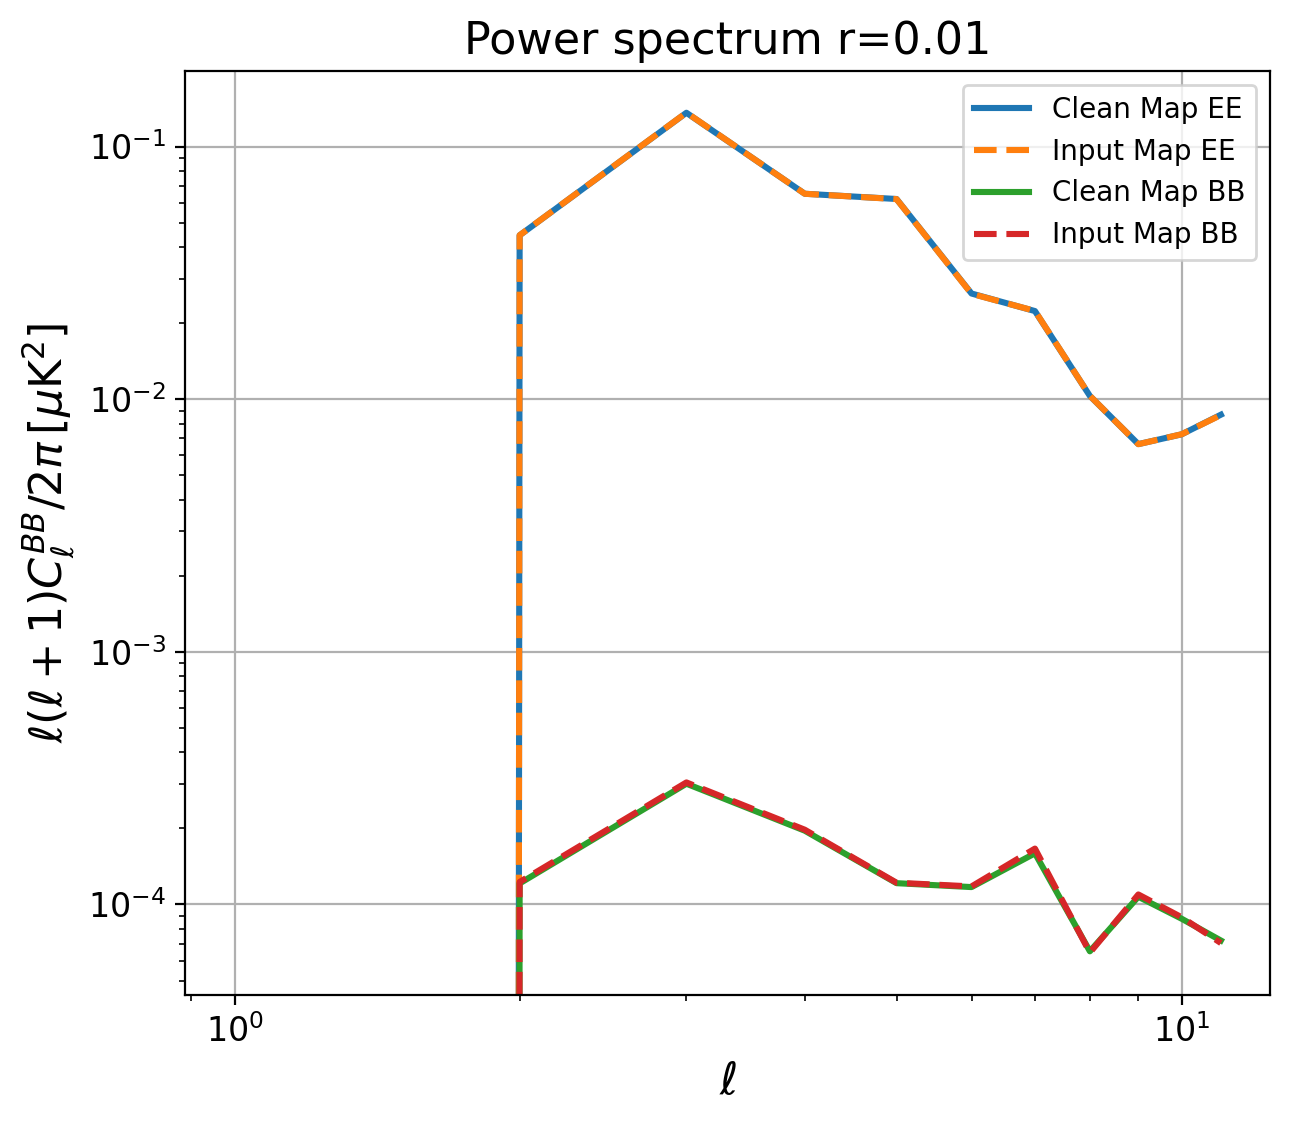

In [91]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")
"""
np.save("dl_file/Clean_dl_s1_EE_new.npy", Clean_map_dl[1])
np.save("dl_file/Input_dl_s1_EE_new.npy", Clean_map_dl[1])
"""

plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

"""
np.save("dl_file/Clean_dl_s1_BB_new.npy", Clean_map_dl[2])
np.save("dl_file/Input_dl_s1_BB_new.npy", Clean_map_dl[2])
"""

plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum r=" + str(r), fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

In [ ]:
"""
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")


plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")


plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum", fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()
"""

In [1]:
import numpy as np

In [9]:
print(np.fft.fftshift(np.fft.fft([1, 2, 3])) / 3) 

[-0.5-0.28867513j  2. +0.j         -0.5+0.28867513j]


In [10]:
print(np.fft.fftshift(np.fft.fft([1, 2, 3, 1, 2, 3])) / 6)

[ 0. +0.j         -0.5-0.28867513j  0. +0.j          2. +0.j
  0. +0.j         -0.5+0.28867513j]
